<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L10/k_armed_bandit_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q values and q tables
In this exercise we will code some strategies to solve the k-armed bandit problem and we will understand the exploration-exploitation dilemma more in detail.

The following cell contains an implementation of a q-value table, the `QTable ` class. As you see, this class has methods to store estimated q-values for state-actions pairs, and a method to return the best action for a given state.
We can think of the Q-table as a vector containing the estimated value for pulling a particular arm:
<div>
<img src="https://isaac-sene.notion.site/image/attachment%3Ac4d0d6ae-05a7-4fed-841a-de6b6644b7d7%3Aimage.png?table=block&id=1ecdc177-9d9b-80ac-a756-c3cf493dce6c&spaceId=a555f58d-e8f0-4d70-ae68-693949f59338&width=2000&userId=&cache=v2" width="500"/>
</div>




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import json
import random
import seaborn as sb


class QTable:
    def __init__(self, alpha=0.1, default_q_value=0.0):
        self.qtable = defaultdict(lambda: default_q_value)
        self.alpha = alpha

    def update(self, state, action, delta):
        self.qtable[(state, action)] = self.qtable[(state, action)] + self.alpha * delta

    def get_q_value(self, state, action):
        return self.qtable[(state, action)]

    def get_q_values(self, states, actions):
        return [self.get_q_value(state, action) for state, action in zip(states, actions)]

    """ Return the action with the maximum Q-value """
    def get_argmax_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return argmax_q

    """ Return a pair containing the action and Q-value, where the
        action has the maximum Q-value in state
    """
    def get_max_pair(self, state, actions):
        max_q = float("-inf")
        max_actions = []
        for action in actions:
            value = self.get_q_value(state, action)
            if value > max_q:
                max_actions = [action]
                max_q = value
            elif value == max_q:
                max_actions += [action]

        arg_max_q = random.choice(max_actions)
        return (arg_max_q, max_q)



## 🥋 $\epsilon$ - gredy policy
Can you implement an $\epsilon$-greedy strategy? The `select` methods must encode the following policy:

\begin{aligned}& A \leftarrow \begin{cases}\arg \max _a \hat{q}(a) & \quad\qquad\qquad\text { with probability } 1-\varepsilon \\\operatorname{arandom} \operatorname{raction} & \quad\qquad\qquad\text { with probability } \varepsilon\end{cases} \end{aligned}

In [2]:
class EpsilonGreedy:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def reset(self):
        pass

    def select(self, state, actions, qfunction):
        # COMPLETE THIS METHOD
        if random.random() < self.epsilon:
            return random.choice(actions)
        arg_max_q = qfunction.get_argmax_q(state, actions)
        return arg_max_q

# K-armed bandits

The next cell define the k-armed bandit game.
* For each episode we pull an arm, observe a reward and update our policy (qtable.update).  

* Each arm can return a coin with a given probability. The true probabilites are encoded in the vector `INIT_P` = $[0.1, 0.3, 0.7, 0.2, 0.1]$.

<div>
<img src="https://isaac-sene.notion.site/image/attachment%3A9425156a-2624-43b6-ab36-86b98193ea0e%3Aimage.png?table=block&id=1ecdc177-9d9b-80b7-a598-f58caaaebd27&spaceId=a555f58d-e8f0-4d70-ae68-693949f59338&width=960&userId=&cache=v2
" width="500"/>
</div>



**Our task is to learn, as fast as we can, the most profitable arm, and exploit this knowledge to maximize the reward.**

You can notice the function accepts also a `drift` parameter, which we'll later use to assess the performance of different policies under a distributional shift, that is, a change in the profitability of the slots machines.

## 🥋 Estimate q-values
Try to complete the expression for `delta`. What's this parameter? Come back to the first cell and try to understand how is it used to update the q value.

In [11]:
INIT_P = [0.1, 0.3, 0.7, 0.2, 0.1]
DRIFTED_P = [0.5, 0.2, 0.0, 0.3, 0.3]


""" Run a bandit algorithm for a number of episodes, with each episode
being a set length.
"""

def run_bandit(bandit, episodes=200, episode_length=500, drift=True, save_q_tables=False, alpha=1):

    # The actions available
    actions = [0, 1, 2, 3, 4]

    # A dummy state
    state = 1

    q_tables = []
    rewards = []
    for _ in range(0, episodes):
        q_tables_ep = []
        bandit.reset()

        # The probability of receiving a payoff for each action
        probabilities = INIT_P

        # The number of times each arm has been selected
        times_selected = defaultdict(lambda: 0)
        qtable = QTable(alpha=alpha)

        episode_rewards = []
        for step in range(0, episode_length):

            # Halfway through the episode, change the probabilities
            if drift and step == episode_length / 2:
                probabilities = DRIFTED_P

            # Select an action using the bandit
            action = bandit.select(state, actions, qtable)

            # Get the reward for that action
            reward = 0
            if random.random() < probabilities[action]:
                reward = 1

            episode_rewards += [reward]

            times_selected[action] = times_selected[action] + 1

            # Update q value ---- COMPLETE THIS
            delta = (reward - qtable.get_q_value(state, action))

            if alpha==1:
              delta /= times_selected[action]

            qtable.update(state, action, delta)

            if save_q_tables and step>0 and len(list(qtable.qtable.values())) >= len(probabilities):
              q_tables_ep.append(np.array([value for key, value in sorted(qtable.qtable.items())]))


        q_tables.append(q_tables_ep)
        rewards += [episode_rewards]
    if save_q_tables:
      return pd.DataFrame(rewards, index=np.arange(episodes), columns=np.arange(episode_length)).T, q_tables
    else:
      return pd.DataFrame(rewards, index=np.arange(episodes), columns=np.arange(episode_length)).T


# Playing the bandit
In the following cell we play a *single* game for 1000 steps, using the $\epsilon$-greedy strategy with $\epsilon = 0.9$.
We observe
1. The reward. Since the reward is binary (blue), we better visualize it using a moving average (rd)
2. The evolution of the estimated q-values, $\hat{q}_{t}$, along with the true value denoted with a star.



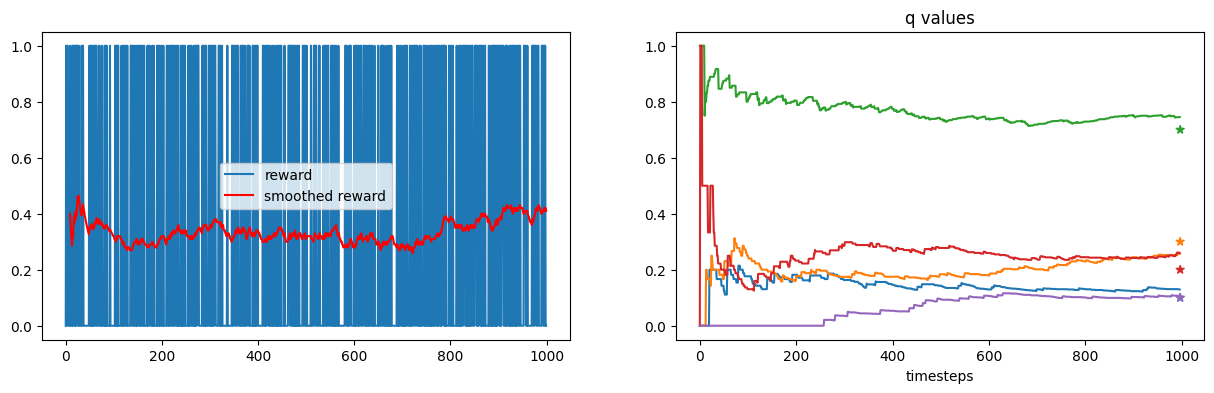

In [12]:

rewards, q_tables = run_bandit(EpsilonGreedy(epsilon=0.9), episodes = 1, episode_length=1000, drift=False, save_q_tables=True)


fig, ax = plt.subplots(1, 2, figsize=(15, 4))
rewards.mean(axis=1).plot(label='reward', ax=ax[0])
rewards.mean(axis=1).rolling(window=100, min_periods=10).mean().plot(color='r', label='smoothed reward', ax=ax[0])
ax[0].legend()

ax[1].plot(np.vstack(q_tables[0]))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]
ax[1].scatter(np.tile(len(q_tables[0]),5), np.array(INIT_P), c=colors, marker='*')
ax[1].set_title('q values')
ax[1].set_xlabel('timesteps');

The results from a particular game are not statistically relevant. To draw some conclusions about different strategies, we have to average results from a pool of experiments. In the following we run a set of 200 games with a fixed strategy. We observe:
1. The rewards in terms of an heatmap. Each row is a timestep, each column a different episode/game.
2. The average reward across episodes for a given timestep (blue), along with its moving average (red)

❓ Why is the reward increasing with time?

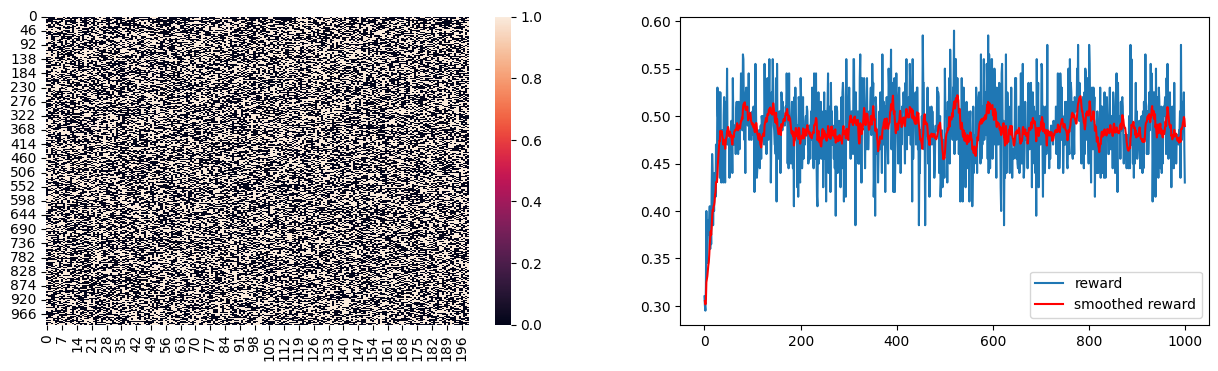

In [13]:
rewards = run_bandit(EpsilonGreedy(epsilon=0.5), episodes = 200, episode_length=1000, drift=False)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sb.heatmap(rewards, ax=ax[0])

rewards.mean(axis=1).plot(ax=ax[1], label='reward')

rewards.mean(axis=1).rolling(window=10, min_periods=2).mean().plot(color='r', ax=ax[1], label='smoothed reward')
plt.legend();

# Impact of $\epsilon$ on greedy strategies
Everything is now set for running some experiments.
We can start exploring the impact of $\epsilon$ over the expected reward.
We observe:
1. On the left, average reward across episodes for different $\epsilon$
2. On the right, the distribution of the terminal estimated q values across episodes, that is $\hat{q}_{t=1000}$

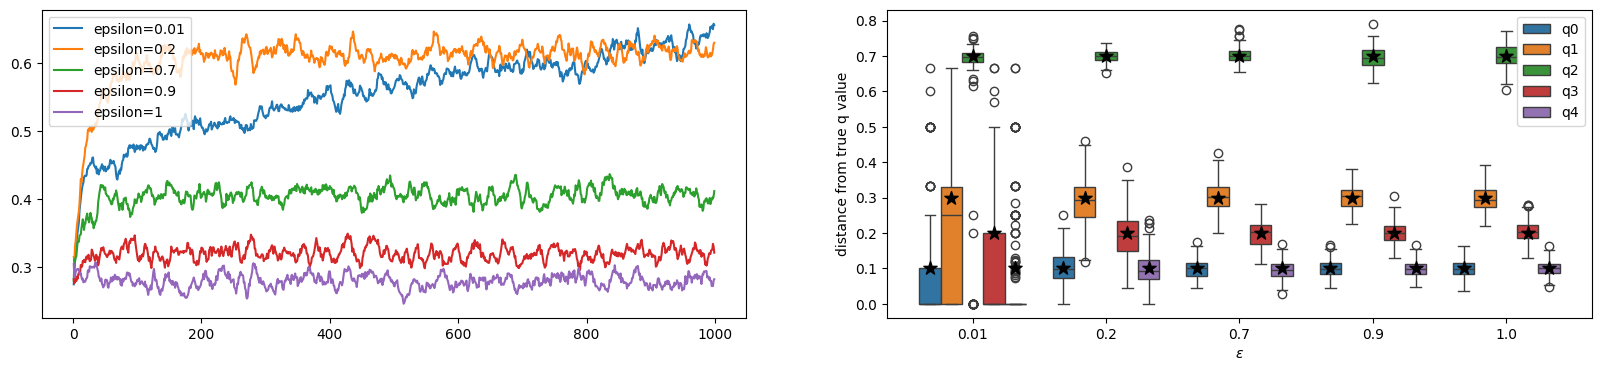

In [23]:
final_estimations = []
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
for epsilon in [0.01, 0.2, 0.7, 0.9, 1]:
    rewards, q_tables = run_bandit(EpsilonGreedy(epsilon=epsilon), drift=False, save_q_tables=True, episode_length=1000)

    # mean reward across episodes
    rewards.mean(axis=1).rolling(window=10, min_periods=2).mean().plot(label=f'epsilon={epsilon}', ax=ax[0])

    # distance from true q value
    final_estimations_eps = pd.DataFrame([q[-1] for q in q_tables], columns=['q0', 'q1', 'q2', 'q3', 'q4']).melt()
    final_estimations_eps[r'$\epsilon$'] = epsilon
    final_estimations.append(final_estimations_eps)



final_estimations = pd.concat(final_estimations)
# plot final estimations as boxplots using seaborn, puttin epsilon on x and making separate boxplots for each column
sb.boxplot(data=final_estimations, x=r'$\epsilon$', y='value', hue='variable', ax=ax[1])
# put stars where the true values are, for all the 5 values, for all the boxplots (5 epsilon values)
for i, epsilon in enumerate(final_estimations[r'$\epsilon$'].unique()):
    deltas = np.linspace(-0.32, 0.32, 5)
    for j, true_value in enumerate(INIT_P):
        ax[1].scatter(i + deltas[j], true_value, marker='*', s=100, color='black', zorder=3)
ax[1].set_ylabel('distance from true q value')
ax[0].legend()
ax[1].legend();


❓ when $\epsilon = 1$, the average reward fluctuates around a given value. What is this value?

In [24]:
print(f'Average R for epsilon = 1: {rewards.mean().mean()}')

Average R for epsilon = 1: 0.28014


# An $\epsilon$-decreasing strategy
Learning a good approximation of the expected reward when pulling an arm is important, but an $\epsilon$-greedy strategy can never exploit the retrieved information to the fullest.

Why so?

❓ Consider $\epsilon$ = 0.2 and two arms, one returning always 1 coin and one returning always 0 coins. What's the expected performance of this $\epsilon$-greedy strategy?


💡 We can achieve a better result if we reduce exploration after a reasonable amount of time. As we observed in the above plots, after 1000 steps most of the $\epsilon$-greedy strategies obtain a good estimate of the q value. This means that after a warm-up, learning phase, we could start to exploit more the retrieved information about the profitability of the arms.

❓ Can you describe what the following strategy is doing?

In [26]:

class EpsilonDecreasing:
    def __init__(self, epsilon=1.0, lambda_decay=0.999, lower_bound=0.1):
        self.epsilon_greedy_bandit = EpsilonGreedy(epsilon)
        self.initial_epsilon = epsilon
        self.lambda_decay = lambda_decay
        self.lower_bound = lower_bound

    def reset(self):
        self.epsilon_greedy_bandit = EpsilonGreedy(self.initial_epsilon)

    def select(self, state, actions, qfunction):
        result = self.epsilon_greedy_bandit.select(state, actions, qfunction)
        self.epsilon_greedy_bandit.epsilon = max(
            self.epsilon_greedy_bandit.epsilon * self.lambda_decay, self.lower_bound
        )
        return result

let's run this new strategy with different values of $\lambda_{decay}$:

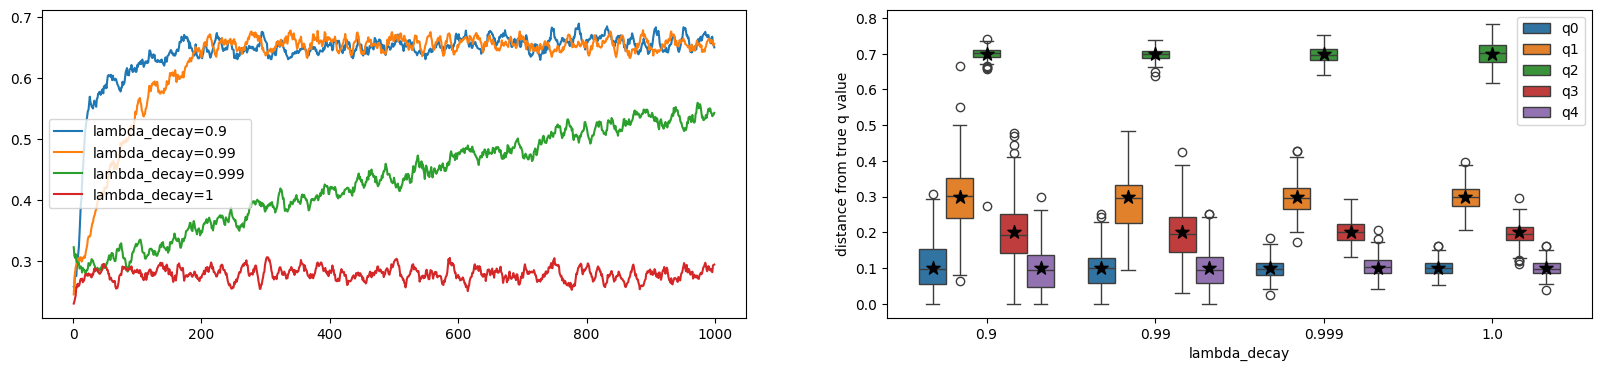

In [36]:
final_estimations = []
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
for lambda_decay in [0.9, 0.99, 0.999, 1]:
    rewards, q_tables = run_bandit(EpsilonDecreasing(lambda_decay=lambda_decay), drift=False, save_q_tables=True, episode_length=1000)

    # mean reward across episodes
    rewards.mean(axis=1).rolling(window=10, min_periods=2).mean().plot(label=f'lambda_decay={lambda_decay}', ax=ax[0])

    # distance from true q value
    final_estimations_eps = pd.DataFrame([q[-1] for q in q_tables], columns=['q0', 'q1', 'q2', 'q3', 'q4']).melt()
    final_estimations_eps['lambda_decay'] = lambda_decay
    final_estimations.append(final_estimations_eps)


final_estimations = pd.concat(final_estimations)
sb.boxplot(data=final_estimations, x='lambda_decay', y='value', hue='variable', ax=ax[1])
for i, lambda_decay in enumerate(final_estimations.lambda_decay.unique()):
    deltas = np.linspace(-0.32, 0.32, 5)
    for j, true_value in enumerate(INIT_P):
        ax[1].scatter(i + deltas[j], true_value, marker='*', s=100, color='black', zorder=3)
ax[1].set_ylabel('distance from true q value')
ax[0].legend()
ax[1].legend();

# Nonstationary setting
How effective are the strategies we've expored so far if the q-values change in time? In the following experiment, we set `drift= True`, which changes the true values for the arms'rewards after 500 steps.

You have possibly noticed that the `run_bandit` function had an $\alpha$ parameter. When $\alpha< 1 $ the estimation method for the q values changes to an exponential moving average.

## 🥋 Try to find the best stragy
Try to combine the previous two stragies with the exponentil moving average estimation to find the best performing strategy.

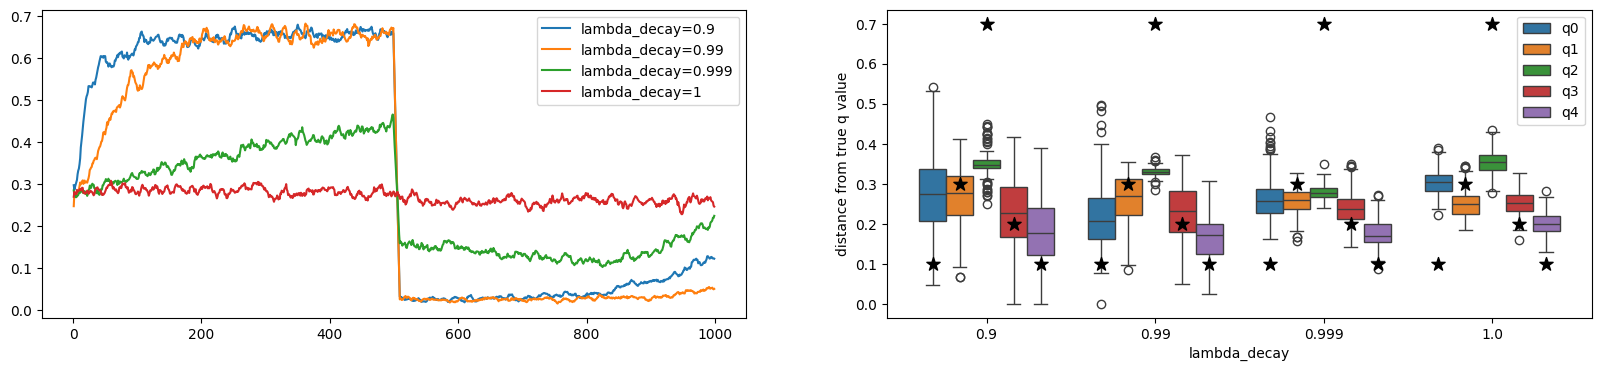

In [39]:
final_estimations = []
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
for lambda_decay in [0.9, 0.99, 0.999, 1]:
    rewards, q_tables = run_bandit(EpsilonDecreasing(lambda_decay=lambda_decay), drift=True, save_q_tables=True, episode_length=1000)

    # mean reward across episodes
    rewards.mean(axis=1).rolling(window=10, min_periods=2).mean().plot(label=f'lambda_decay={lambda_decay}', ax=ax[0])

    # distance from true q value
    final_estimations_eps = pd.DataFrame([q[-1] for q in q_tables], columns=['q0', 'q1', 'q2', 'q3', 'q4']).melt()
    final_estimations_eps['lambda_decay'] = lambda_decay
    final_estimations.append(final_estimations_eps)


final_estimations = pd.concat(final_estimations)
sb.boxplot(data=final_estimations, x='lambda_decay', y='value', hue='variable', ax=ax[1])
for i, lambda_decay in enumerate(final_estimations.lambda_decay.unique()):
    deltas = np.linspace(-0.32, 0.32, 5)
    for j, true_value in enumerate(INIT_P):
        ax[1].scatter(i + deltas[j], true_value, marker='*', s=100, color='black', zorder=3)
ax[1].set_ylabel('distance from true q value')
ax[0].legend()
ax[1].legend();